In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42615")
client

<Client: 'tcp://127.0.0.1:42615' processes=8 threads=64, memory=235.96 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.interpolate import interp2d
from xgcm.grid import Grid
import gsw
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from validate_catalog import all_params
params_dict, cat = all_params()

hycom50_grid = cat.HYCOM50(region='1_GS', datatype='grid', grid='grid').to_dask()

In [5]:
hycom01ww = cat.HYCOM50(region='1_GS', datatype='int_wvel', season='fma', decode_times=False).to_dask()
hycom01ww

<xarray.Dataset>
Dimensions:    (lat: 615, lay: 32, lon: 503, time: 90)
Coordinates:
  * time       (time) float32 398.0 399.0 400.0 401.0 ... 485.0 486.0 487.0
Dimensions without coordinates: lat, lay, lon
Data variables:
    latitude   (lat) float32 dask.array<chunksize=(615,), meta=np.ndarray>
    layer      (lay) float32 dask.array<chunksize=(32,), meta=np.ndarray>
    longitude  (lon) float32 dask.array<chunksize=(503,), meta=np.ndarray>
    wvel       (time, lay, lat, lon) float32 dask.array<chunksize=(4, 32, 615, 503), meta=np.ndarray>

In [17]:
hycom01w = cat.HYCOM50(region='1_GS', datatype='int', season='fma', decode_times=False).to_dask()
u3 = hycom01w.u3
v3 = hycom01w.v3
hycom01w = hycom01w.drop('u3')
hycom01w = hycom01w.drop('v3')
Ny = len(hycom50_grid.lat)
Nx = len(hycom50_grid.lon)
hycom01w['u3'] = xr.DataArray(u3.data, dims=['time','lay','lat','lonG'],
                              coords={'time':hycom01w.time,'lay':hycom01w.lay,
                                      'lat':hycom01w.lat,'lonG':np.arange(-.5,Nx-.5,1)}
                             )
hycom01w['v3'] = xr.DataArray(v3.data, dims=['time','lay','latG','lon'],
                              coords={'time':hycom01w.time,'lay':hycom01w.lay,
                                      'latG':np.arange(-.5,Ny-.5,1),'lon':hycom01w.lon}
                             )
hycom01w.coords['layl'] = np.arange(-.5,31,1)
hycom01w['w3'] = xr.DataArray(hycom01ww.wvel.data, dims=['time','layl','lat','lon'],
                              coords={'time':hycom01w.time,'layl':hycom01w.layl,
                                      'lat':hycom01w.lat,'lon':hycom01w.lon}
                             )
hycom01w

<xarray.Dataset>
Dimensions:    (lat: 615, latG: 615, lay: 32, layl: 32, lon: 503, lonG: 503, time: 90)
Coordinates:
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502
  * lay        (lay) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * lat        (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * lonG       (lonG) float64 -0.5 0.5 1.5 2.5 3.5 ... 498.5 499.5 500.5 501.5
  * latG       (latG) float64 -0.5 0.5 1.5 2.5 3.5 ... 610.5 611.5 612.5 613.5
  * layl       (layl) float64 -0.5 0.5 1.5 2.5 3.5 ... 26.5 27.5 28.5 29.5 30.5
Data variables:
    h3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 615, 503), meta=np.ndarray>
    latitude   (lat) float32 dask.array<chunksize=(615,), meta=np.ndarray>
    layer      (lay) float32 dask.array<chunksize=(32,), meta=np.ndarray>
    longitude  (lon) float32 dask.array<chunksize=(503,), meta=np.ndarray>
    s3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 615, 503), meta=np.ndarray>
    t3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 615, 503), meta=np.ndarray>
    u3         (time, lay, lat, lonG) float32 dask.array<chunksize=(24, 32, 615, 503), meta=np.ndarray>
    v3         (time, lay, latG, lon) float32 dask.array<chunksize=(24, 32, 615, 503), meta=np.ndarray>
    w3         (time, layl, lat, lon) float32 dask.array<chunksize=(4, 32, 615, 503), meta=np.ndarray>

In [8]:
h3l = xr.DataArray(xr.concat([.5*hycom01w.h3.isel(lay=0), .5*(hycom01w.h3.isel(lay=slice(None,-1)).data
                                                              + hycom01w.h3.isel(lay=slice(1,None)))
                             ], 'lay').transpose('time','lay','lat','lon').data,
                   dims=['time','layl','lat','lon'],
                   coords={'time':hycom01w.time,'layl':hycom01w.layl,
                           'lat':hycom01w.lat,'lon':hycom01w.lon}
                  )
h3l

<xarray.DataArray 'transpose-a03e546be65d2efe49b84b5da9426539' (time: 90, layl: 32, lat: 615, lon: 503)>
dask.array<transpose, shape=(90, 32, 615, 503), dtype=float32, chunksize=(24, 31, 615, 503), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * layl     (layl) float64 -0.5 0.5 1.5 2.5 3.5 ... 26.5 27.5 28.5 29.5 30.5
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502

In [9]:
Zl = h3l.cumsum('layl',skipna=True)
Zl = Zl.where(Zl>0.)
Z = hycom01w.h3.cumsum('lay',skipna=True)
Z = Z.where(Z>0.)
Z

<xarray.DataArray 'h3' (time: 90, lay: 32, lat: 615, lon: 503)>
dask.array<where, shape=(90, 32, 615, 503), dtype=float32, chunksize=(24, 32, 615, 503), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502
  * lay      (lay) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89

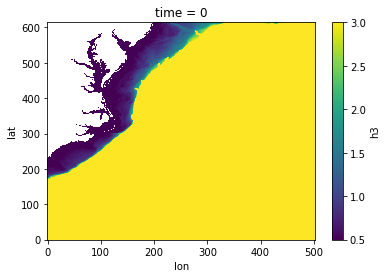

In [13]:
Z.isel(time=0,lay=0).plot()

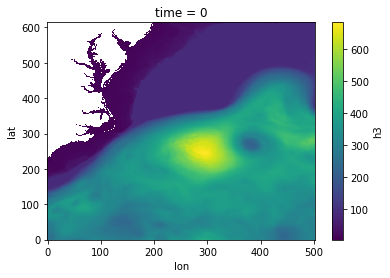

In [14]:
Z.isel(time=0,lay=10).plot()

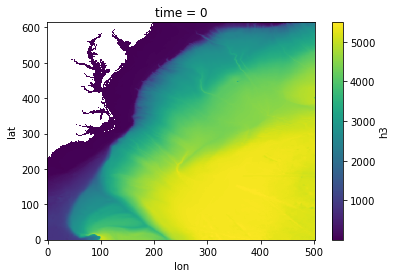

In [15]:
Z.isel(time=0,lay=-1).plot()

In [19]:
hycom01w['Z'] = Z
hycom01w['Zl'] = Zl

coords={'T':{'center':'time'},
        'X':{'center':'lon', 'left':'lonG'}, 
        'Y':{'center':'lat', 'left':'latG'}, 
        'Z':{'center':'lay', 'left':'layl'}
       }

grid = Grid(hycom01w, coords=coords, periodic=[])
grid

<xgcm.Grid>
T Axis (not periodic, boundary=None):
  * center   time
X Axis (not periodic, boundary=None):
  * center   lon --> left
  * left     lonG --> center
Y Axis (not periodic, boundary=None):
  * center   lat --> left
  * left     latG --> center
Z Axis (not periodic, boundary=None):
  * center   lay --> left
  * left     layl --> center

In [20]:
hycom01w['Zu'] = grid.interp(Z, 'X', boundary='fill')
hycom01w['Zv'] = grid.interp(Z, 'Y', boundary='fill')

In [21]:
xx, yy = np.meshgrid(hycom50_grid.longitude, hycom50_grid.latitude)
dxF = xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                   coords={'lat':hycom01w.lat,'lon':np.arange(.5,Nx-1,1)}
                  ).interp(lon=hycom01w.lon, method="linear",
                           kwargs={"fill_value": "extrapolate"})
dyF = xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                   coords={'lat':np.arange(.5,Ny-1,1),'lon':hycom01w.lon}
                  ).interp(lat=hycom01w.lat, method="linear",
                           kwargs={"fill_value": "extrapolate"})
dxC = xr.DataArray(xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                                coords={'lat':hycom01w.lat,'lon':np.arange(.5,Nx-1,1)}
                               ).interp(lon=hycom01w.lonG, method="linear",
                                        kwargs={"fill_value": "extrapolate"}),
                   dims=['lat','lonG'],
                   coords={'lat':hycom01w.lat,'lonG':hycom01w.lonG}
                  )
dyC = xr.DataArray(xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                                coords={'lat':np.arange(.5,Ny-1,1),'lon':hycom01w.lon}
                               ).interp(lat=hycom01w.latG, method="linear",
                                        kwargs={"fill_value": "extrapolate"}),
                   dims=['latG','lon'],
                   coords={'latG':hycom01w.latG,'lon':hycom01w.lon}
                  )
dxG = xr.DataArray(xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                                coords={'lat':hycom01w.lat,'lon':np.arange(.5,Nx-1,1)}
                               ).interp(lon=hycom01w.lon, method="linear",
                                        kwargs={"fill_value": "extrapolate"}
                                       ).interp(lat=hycom01w.latG, method='linear',
                                                kwargs={"fill_value": "extrapolate"}),
                   dims=['latG','lon'],
                   coords={'latG':hycom01w.latG,'lon':hycom01w.lon}
                  )
dyG = xr.DataArray(xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                                coords={'lat':np.arange(.5,Ny-1,1),'lon':hycom01w.lon}
                               ).interp(lat=hycom01w.lat, method="linear",
                                        kwargs={"fill_value": "extrapolate"}
                                       ).interp(lon=hycom01w.lonG, method='linear',
                                                kwargs={"fill_value": "extrapolate"}),
                   dims=['lat','lonG'],
                   coords={'lat':hycom01w.lat,'lonG':hycom01w.lonG}
                  )

hycom01w['dxF'] = dxF
hycom01w['dyF'] = dyF
hycom01w['dxC'] = dxC
hycom01w['dyC'] = dyC
hycom01w['dxG'] = dxG
hycom01w['dyG'] = dyG
hycom01w

<xarray.Dataset>
Dimensions:    (lat: 615, latG: 615, lay: 32, layl: 32, lon: 503, lonG: 503, time: 90)
Coordinates:
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502
  * lay        (lay) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * lat        (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * lonG       (lonG) float64 -0.5 0.5 1.5 2.5 3.5 ... 498.5 499.5 500.5 501.5
  * latG       (latG) float64 -0.5 0.5 1.5 2.5 3.5 ... 610.5 611.5 612.5 613.5
  * layl       (layl) float64 -0.5 0.5 1.5 2.5 3.5 ... 26.5 27.5 28.5 29.5 30.5
Data variables: (12/19)
    h3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 615, 503), meta=np.ndarray>
    latitude   (lat) float32 dask.array<chunksize=(615,), meta=np.ndarray>
    layer      (lay) float32 dask.array<chunksize=(32,), meta=np.ndarray>
    longitude  (lon) float32 dask.array<chunksize=(503,), meta=np.ndarray>
    s3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 615, 503), meta=np.ndarray>
    t3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 615, 503), meta=np.ndarray>
    ...         ...
    dxF        (lat, lon) float64 1.925e+03 1.925e+03 ... 1.702e+03 1.702e+03
    dyF        (lat, lon) float64 1.926e+03 1.926e+03 ... 1.703e+03 1.703e+03
    dxC        (lat, lonG) float64 1.925e+03 1.925e+03 ... 1.702e+03 1.702e+03
    dyC        (latG, lon) float64 1.926e+03 1.926e+03 ... 1.703e+03 1.703e+03
    dxG        (latG, lon) float64 1.925e+03 1.925e+03 ... 1.702e+03 1.702e+03
    dyG        (lat, lonG) float64 1.926e+03 1.926e+03 ... 1.703e+03 1.703e+03

In [13]:
zs = np.concatenate((np.linspace(3,35.97241992,10, endpoint=False), (1+np.tanh(np.linspace(-2,0,40)))*1e3))
zp1s = np.concatenate((np.array([1.5]),.5*(zs[1:] + zs[:-1])))
from scipy.interpolate import interp1d
f = interp1d(np.arange(len(np.diff(zp1s))), np.abs(np.diff(zp1s)), fill_value='extrapolate')
dzp1s = f(np.arange(len(np.diff(zp1s))+1))
dzp1s

array([ 3.148621  ,  3.29724199,  3.29724199,  3.29724199,  3.29724199,
        3.29724199,  3.29724199,  3.29724199,  3.29724199,  3.29724199,
        3.55264146,  4.00508682,  4.41857019,  4.87252431,  5.37042207,
        5.91592588,  6.51287229,  7.1652487 ,  7.87716075,  8.65278859,
        9.49632995, 10.41192823, 11.40358345, 12.47504419, 13.62967876,
       14.8703244 , 16.19911391, 17.61728007, 19.12493942, 20.72085899,
       22.40221107, 24.16432403, 26.00043946, 27.90148896, 29.85590644,
       31.84949421, 33.86536253, 35.8839629 , 37.88323384, 39.83887484,
       41.72475863, 43.51348399, 45.17706184, 46.68771554, 48.01876536,
       49.1455555 , 50.04637364, 50.70330799, 51.10298599, 51.50266399])

In [16]:
hycom01w.Zl

<xarray.DataArray 'Zl' (time: 90, layl: 32, lat: 615, lon: 503)>
dask.array<where, shape=(90, 32, 615, 503), dtype=float32, chunksize=(24, 31, 615, 503), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * layl     (layl) float64 -0.5 0.5 1.5 2.5 3.5 ... 26.5 27.5 28.5 29.5 30.5

In [23]:
ww = grid.transform(hycom01w.w3.chunk({'layl':-1}).astype(np.float64), 
                    'Z', zs, target_data=hycom01w.Zl.chunk({'layl':-1}))
ww

<xarray.DataArray 'w3' (time: 90, lat: 615, lon: 503, Zl: 50)>
dask.array<transpose, shape=(90, 615, 503, 50), dtype=float64, chunksize=(4, 615, 503, 50), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * Zl       (Zl) float64 3.0 6.297 9.594 12.89 ... 847.4 897.8 948.8 1e+03

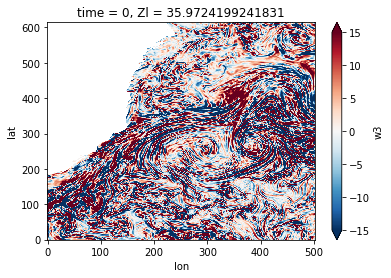

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [26]:
(ww*86400).isel(time=0,Zl=10).plot(vmax=15)